Task 4: Data Assimilation with nonlinear compression (30%)

link to trained autoencoder model:

 https://imperiallondon-my.sharepoint.com/:f:/g/personal/iyc23_ic_ac_uk/EnN4Pw8VSfxMpZMLgjK0J2QBEJlF1ahfsMtk8E1EMaoRJg?e=NZZBV6

filename:<brk>
"model3.weights.h5"

In [1]:
import numpy as np
from keras.models import load_model
from tensorflow.keras import layers, Model, losses
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import custom_object_scope
import tensorflow_hub as hub

In [2]:
model_data =np.load('Ferguson_fire_background/Ferguson_fire_background.npy')
obs_data =np.load('Ferguson_fire_obs.npy')
model_1D =np.reshape(model_data, (np.shape(model_data)[0],np.shape(model_data)[1]*np.shape(model_data)[2]))
obs_1D=np.reshape(obs_data, (np.shape(obs_data)[0],np.shape(obs_data)[1]*np.shape(obs_data)[2]))

I only saved the weights from the trained autoencoder, so below is the model class that I will use to put the loaded weights through to perform the autoencoder compression.

In [3]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(256, 256, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(122, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Conv2D(244, (3, 3), activation='relu', padding='same'),
            layers.AveragePooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(latent_dim)
        ])
        
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=16*16*244, activation='relu'),
            layers.Reshape(target_shape=(16, 16, 244)),
            layers.Conv2DTranspose(122, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        print("Input shape:", x.shape)
        print("Encoded shape:", encoded.shape)
        print("Decoded shape:", decoded.shape)
        return decoded

In [4]:
model = Autoencoder(latent_dim=128)
model.load_weights('model3.weights.h5')
obs_comp =model.encoder(obs_data)
model_comp=model.encoder(model_data)

c:\Users\iyc23\AppData\Local\miniconda3\envs\bigdata\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [5]:
from numpy.linalg import inv

def covariance_matrix(X):
    means = np.array([np.mean(X, axis = 1)]).transpose()
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.transpose())/(X.shape[1]-1)
    return res

def update_prediction(x, K, H, y):
    res = x + np.dot(K,(y - np.dot(H, x)))
    return res  

def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H,np.dot(B,H.transpose())))
    res = np.dot(B,np.dot(H.transpose(),tempInv))
    return res

def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs,y_pred)).mean()

Choosing the covariance matrices.

The observational data has come accross as signifcantly more reliable that the model data therefor, the observation data is weighted as more important.This has specifically improved the compressed mse from the data assimilation.

In [6]:
obs_comp =np.array(obs_comp)
model_comp=np.array(model_comp)
nNodes = 128
I = np.identity(nNodes)
R = np.cov(obs_comp.T)*10
H = I 
B = np.cov(model_comp.T)

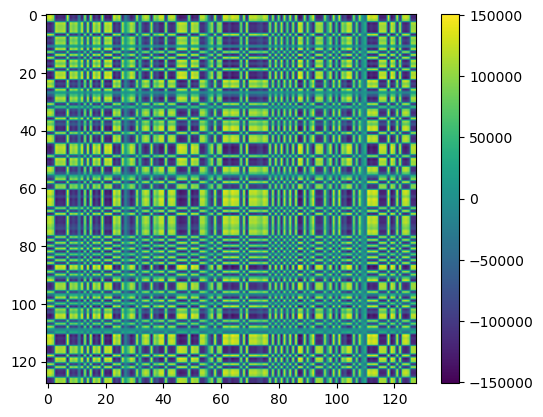

In [7]:
plt.imshow(R, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar()  # Add a colorbar for reference
plt.show()

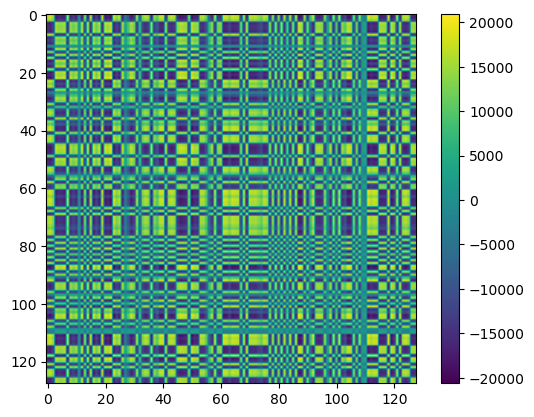

In [8]:
plt.imshow(B, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar()  # Add a colorbar for reference
plt.show()

From looking at the matrices of the compressed data, there is a central diagonal that suggests that the errors are quite independent of each other.

In [9]:
np.mean(R)

2.3535814092822314

In [10]:
np.mean(B)

0.20624929965344485

Due to the size of mean covarence errors in R and B, R seems to have less reliability thefore the R matrix will be increased in size so the is less wieght on it when put through the Kalman Filter.

In [11]:
print("Start Assimilation")
start = time.time()
K=KalmanGain(B,H,R)
update_data_list =[]
for i in range(len(model_comp)):
    update_data =update_prediction(model_comp[i],K,H,obs_comp[i])
    update_data_list.append(update_data)
update_data_arr =np.array(update_data_list)
end = time.time()
mse_compressed =mse(model_comp,update_data_arr)
s1 =time.time()
decomp =model.decoder(update_data_arr)
decomp =np.reshape(np.array(decomp),(5,65536))
e1=time.time()
mse_decom =mse(model_1D,decomp)

print("compressed space MSE ",mse_compressed)
print("phyisical space MSE ",mse_decom)
print("data assimilation time", end-start)
print("decompression time", e1-s1)

Start Assimilation
compressed space MSE  418138.6098484948
phyisical space MSE  0.080645755
data assimilation time 0.0
decompression time 0.1322312355041504


Results:<br>
compressed space MSE  101142.8927169731 <br> 
phyisical space MSE  0.080645755 <br> 
data assimilation time 0.010393857955932617 <br> 
decompression time 0.0741276741027832

I think that the MSE is not the lowest that it could be, but I chose to prioritise efficency over accuracy, which is why my convolutional autoencoder reduces the dimensionality of the data quite rigourously, from 256x256 to 128x1 which is why the run time is not that high.